In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

        收盤價  Unnamed: 1
0     38.05         NaN
1     38.69         NaN
2     39.00         NaN
3     39.26         NaN
4     41.00         NaN
5     41.19         NaN
6     41.22         NaN
7     40.05         NaN
8     39.91         NaN
9     40.66         NaN
10    40.19         NaN
11    40.85         NaN
12    39.80         NaN
13    39.92         NaN
14    39.40         NaN
15    39.98         NaN
16    40.05         NaN
17    41.23         NaN
18    41.23         NaN
19    41.58         NaN
20    41.02         NaN
21    40.60         NaN
22    40.87         NaN
23    41.60         NaN
24    41.40         NaN
25    40.50         NaN
26    40.23         NaN
27    40.70         NaN
28    40.18         NaN
29    40.10         NaN
...     ...         ...
1433  81.85         NaN
1434  81.75         NaN
1435  82.55         NaN
1436  82.70         NaN
1437  82.55         NaN
1438  82.30         NaN
1439  82.70         NaN
1440  82.95         NaN
1441  83.00         NaN
1442  82.85     

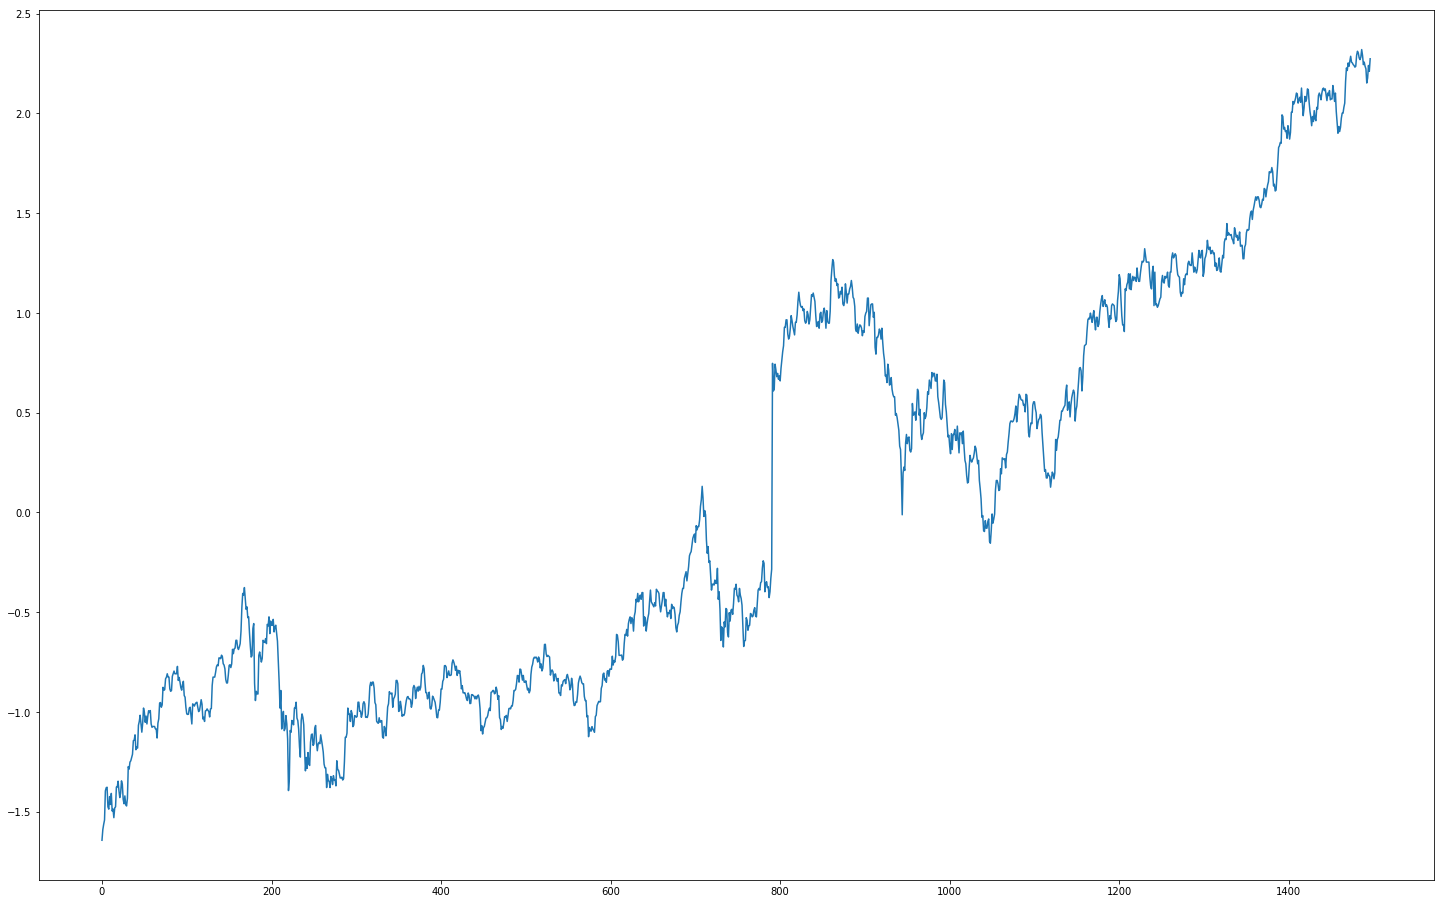

In [18]:
f = open('C:/股市cutdata/datamix.csv','r')  
f_n = open('C:/股市cutdata/datamixnew.csv','r')  

df = pd.read_csv(f)
df_n=pd.read_csv(f_n)

print(df)


data = np.array(df["收盤價"])
data_test=np.array(df_n["收盤價"])
 
#轉str into float
#for i in range(data.size):
#    data[i] = data[i].replace(',','')
#    data[i] = float(data[i])


#標準化資料
normalize_data = (data - np.mean(data)) / np.std(data)
normalize_data = normalize_data[:,np.newaxis]

normalize_data_new = (data_test - np.mean(data)) / np.std(data)
normalize_data_new = normalize_data_new[:,np.newaxis]
figuremix=np.append(normalize_data,normalize_data_new)

plt.figure(figsize=(25, 16))
plt.plot(figuremix)
plt.show()

In [19]:
time_step = 20  #時間單位
rnn_unit = 10   
batch_size = 60  #批次資料
input_size = 1   #輸入維度
output_size = 1   #輸出維度
lr = 0.0006   #學習效率
train_x,train_y = [],[]   #資料集

#輸入資料進資料集
for i in range(len(normalize_data) - time_step - 1):
    x = normalize_data[i:i + time_step]#這一步=x
    y = normalize_data[i + 1:i + time_step + 1]  #下一步=y
    train_x.append(x.tolist())
    train_y.append(y.tolist())


X = tf.placeholder(tf.float32, [None,time_step,input_size])    #X資料
Y = tf.placeholder(tf.float32, [None,time_step,output_size])   #y資料

#權重 input &output
weights = {
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases = {
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
        }

In [20]:
#————————————————————————————————————
def lstm(batch):      
    w_in = weights['in']
    b_in = biases['in']
    input = tf.reshape(X,[-1,input_size])  
    input_rnn = tf.matmul(input,w_in) + b_in
    input_rnn = tf.reshape(input_rnn,[-1,time_step,rnn_unit])  
    cell = tf.nn.rnn_cell.BasicRNNCell(rnn_unit,reuse=tf.AUTO_REUSE )
    init_state = cell.zero_state(batch,dtype=tf.float32)
    output_rnn,final_states = tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  
    output = tf.reshape(output_rnn,[-1,rnn_unit]) 
    w_out = weights['out']
    b_out = biases['out']
    pred = tf.matmul(output,w_out) + b_out
    return pred,final_states

In [21]:
#————————————————————————————————————
def train_lstm():
    global batch_size
    pred,_ = lstm(batch_size)
    
    loss = tf.reduce_mean(tf.square(tf.reshape(pred,[-1]) - tf.reshape(Y, [-1])))
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    saver = tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
      
        for i in range(500):
            step = 0
            start = 0
            end = start + batch_size
            while(end < len(train_x)):
                _,loss_ = sess.run([train_op,loss],feed_dict={X:train_x[start:end],Y:train_y[start:end]})
                start+=batch_size
                end = start + batch_size
              
                if step % 10 == 0:
                    print(i,step,loss_)
                    print("保存模型：",saver.save(sess,'C:/Users/bambo/Desktop/stock.model/stock.model'))
                step+=1

In [ ]:
train_lstm()

In [22]:
def prediction():
    pred,_ = lstm(1)   # lstm--> return pred,final_states
    saver = tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #讀取訓練模型
        module_file = tf.train.latest_checkpoint('C:/Users/bambo/Desktop/stock.model/','checkpoint')
        saver.restore(sess, module_file) 


        prev_seq = train_x[-1]  #資料集最後一個的位置
        
        predict = []
        predict_self = []
        self_data=[]

        #自我數據比較
        for i in range(len(normalize_data) - time_step ):
            try:
                next_seq = sess.run(pred,feed_dict={X:[train_x[i]]})
            except IndexError:
                continue
            predict_self.append(next_seq[-1])
            
            self_data.append(train_x[i][19][0])



        #未來數據比較
        for i in range(10):
            next_seq = sess.run(pred,feed_dict={X:[prev_seq]})  #餵數據最後一個給DL
            predict.append(next_seq[-1])    #新數據就是預測結果  存起來
            prev_seq = np.vstack((prev_seq[1:],next_seq[-1]))#新數據放到數據列最後一個



        plt.figure(figsize=(25, 16))
        plt.plot(figuremix, color='b')    #原始資料
        plt.plot(list(range(time_step  ,len(predict_self) + time_step )), predict_self, color='g')    #自我預測
        plt.plot(list(range(len(predict_self) + time_step , len(predict_self) + time_step + len(predict) )), predict, color='r')   #未來預測
        plt.show()

INFO:tensorflow:Restoring parameters from C:/Users/bambo/Desktop/stock.model/stock.model


INFO:tensorflow:Restoring parameters from C:/Users/bambo/Desktop/stock.model/stock.model


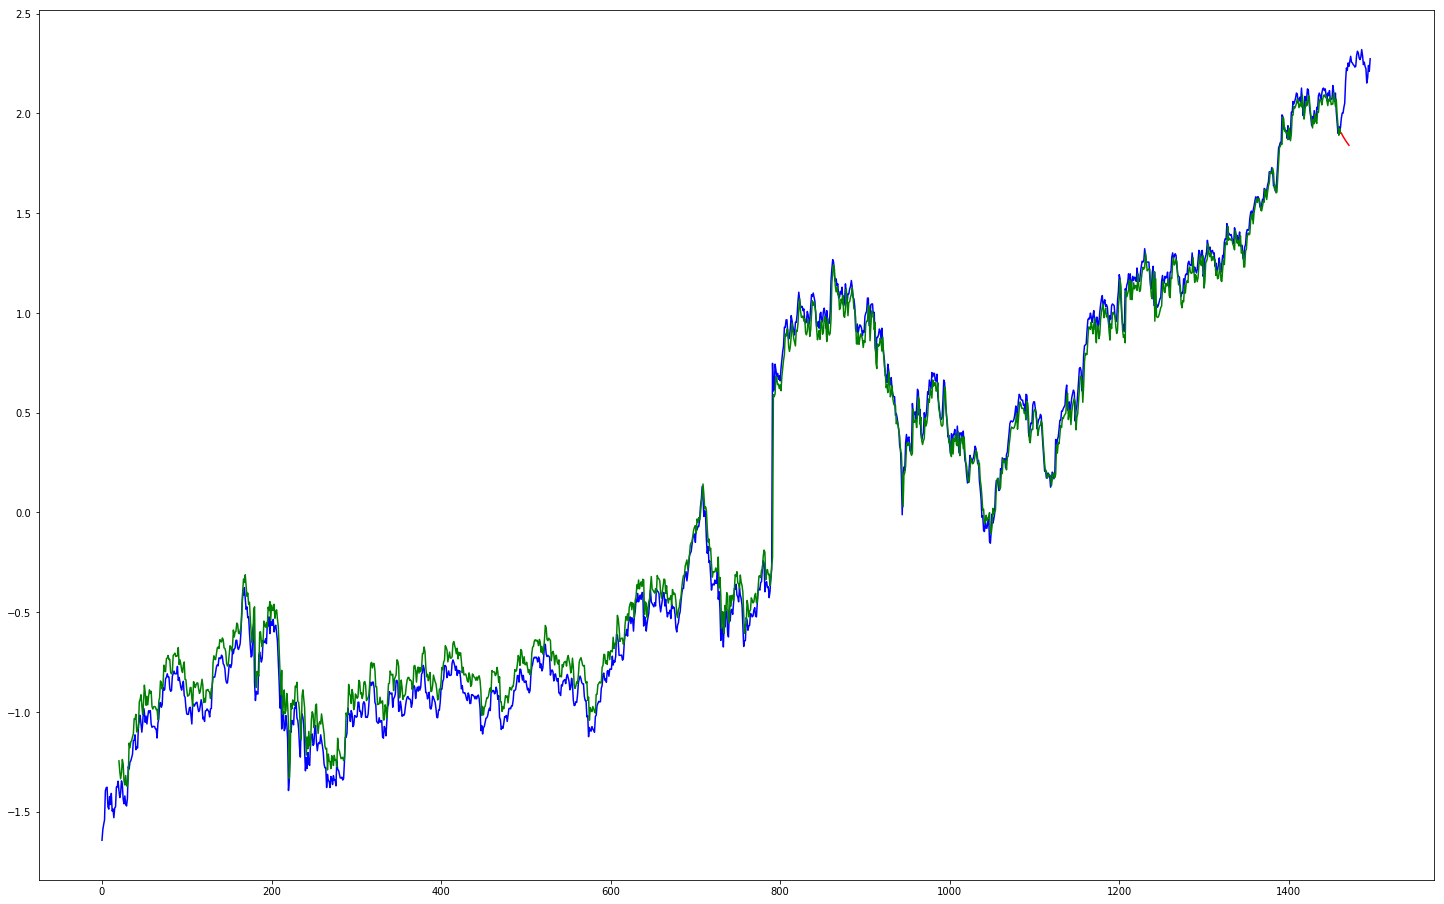

In [23]:
prediction() 